In [1]:
import IPython
import sys
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import find_peaks

if '..' not in sys.path:
    sys.path.insert(0, '..')
    
from modulos.sigproc import framesig
from modulos.faps import energia, ZCR
import pandas as pd

import librosa
import librosa.display

In [2]:
speech_list = glob.glob('../som/*.wav')
speech_list.sort()
speech_list

['../som/aplausosPedro.wav',
 '../som/avsn3.wav',
 '../som/faban3.wav',
 '../som/pedroivo.wav',
 '../som/slnccn3.wav',
 '../som/vjdvn3.wav']

In [3]:
choose_audio = speech_list[0]
IPython.display.Audio(f'{choose_audio}', rate=16000)

In [4]:
sinal, fs = librosa.load(choose_audio, sr=16000)
Ts=1/fs

print(f'Frequência: {fs}Hz')
print(f'Amostras: {len(sinal)}')
print(f'Duração do sinal: {len(sinal)/fs}s')

Frequência: 16000Hz
Amostras: 45352
Duração do sinal: 2.8345s


In [5]:
amostras_ms = int(fs / 1000)
frame_time = 20
amostras_frame = amostras_ms * frame_time
nFrames = int(len(sinal) / amostras_frame)      
print(f'Número de amostras/frames : {amostras_frame}')
print ('Número de frames:', nFrames)

Número de amostras/frames : 320
Número de frames: 141


In [6]:
pre_emphasis = 0.97
emphasized_signal = np.append(sinal[0], sinal[1:] - pre_emphasis * sinal[:-1])

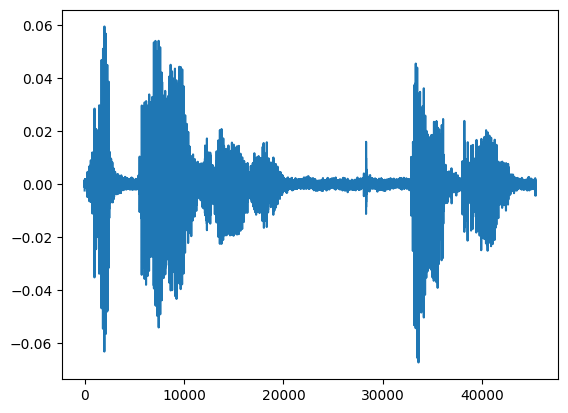

In [7]:
plt.plot(emphasized_signal)

In [8]:
def stride_trick(a, stride_length, stride_step):
    """
    apply framing using the stride trick from numpy.

    Args:
     a (array) : signal array.
     stride_length (int) : length of the stride.
     stride_step (int) : stride step.

    Returns:
     blocked/framed array.
    """
    nrows = ((a.size - stride_length) // stride_step) + 1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a,
                                        shape=(nrows, stride_length),
                                        strides=(stride_step*n, n))


def framing(sig, fs=16000, win_len=0.025, win_hop=0.01):
    """
    transform a signal into a series of overlapping frames (=Frame blocking).

    Args:
     sig     (array) : a mono audio signal (Nx1) from which to compute features.
     fs        (int) : the sampling frequency of the signal we are working with.
                       Default is 16000.
     win_len (float) : window length in sec.
                       Default is 0.025.
     win_hop (float) : step between successive windows in sec.
                       Default is 0.01.

    Returns:
     array of frames.
     frame length.

    Notes:
    ------
     Uses the stride trick to accelerate the processing.
    """
    # run checks and assertions
    if win_len < win_hop: print("ParameterError: win_len must be larger than win_hop.")

    # compute frame length and frame step (convert from seconds to samples)
    frame_length = win_len * fs
    frame_step = win_hop * fs
    signal_length = len(sig)
    frames_overlap = frame_length - frame_step

    # compute number of frames and left sample in order to pad if needed to make
    # sure all frames have equal number of samples  without truncating any samples
    # from the original signal
    rest_samples = np.abs(signal_length - frames_overlap) % np.abs(frame_length - frames_overlap)
    pad_signal = np.append(sig, np.array([0] * int(frame_step - rest_samples) * int(rest_samples != 0.)))

    # apply stride trick
    frames = stride_trick(pad_signal, int(frame_length), int(frame_step))
    return frames, frame_length

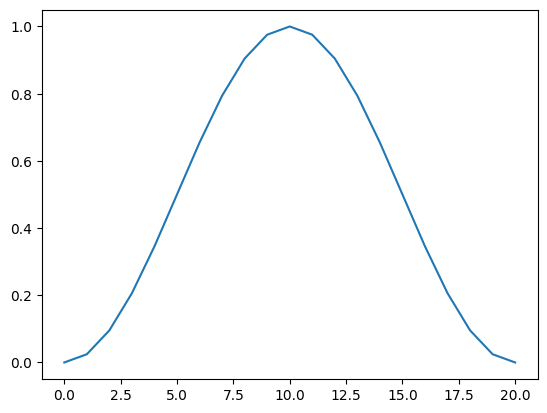

In [9]:
window = np.hanning(21)
plt.plot(window)

In [10]:
frames, frame_length = framing(emphasized_signal, win_len=0.02, win_hop=0.01)
frames *= np.hamming(frame_length)
print(frame_length)
print(len(frames))

320.0
283


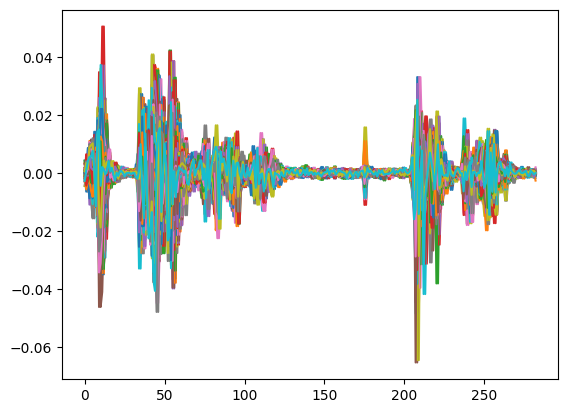

In [11]:
plt.plot(frames)
plt.show()

In [15]:
ZCCs = []                                     
for i in range(len(frames)):
    s = frames[i]         
    ZCC = 0
    #Implementação da Equação
    for k in range(1, len(s)):
        ZCC += 0.5 * abs(np.sign(s[k]) - np.sign(s[k - 1]))
    ZCCs.append(ZCC)

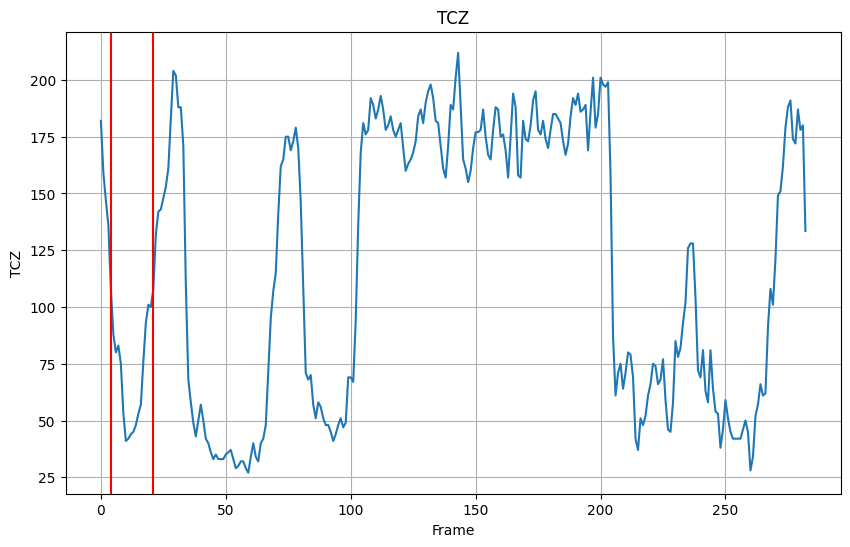

In [16]:
plt.figure(figsize=(10,6)) 
plt.plot(ZCCs)
plt.grid()
plt.title('TCZ'),plt.ylabel('TCZ'), plt.xlabel('Frame')
plt.axvline(x = 4, color = 'r')
plt.axvline(x = 21, color = 'r')

In [17]:
detecVoz = []
detecSilencio = []
sinal_vozeado = []

for l in range(len(frames)):
    
    ehVoz = 0
    ehSilencio = 0
    
    if ZCCs[l] > 125:
       
        ehVoz = 0
        ehSilencio = 1
    
    else:
       
        ehSilencio = 0
        ehVoz = 1
        #if l < 22:
        sinal_vozeado.append(frames[l])
    detecVoz.append(ehVoz)
    detecSilencio.append(ehSilencio)

<Figure size 640x480 with 0 Axes>

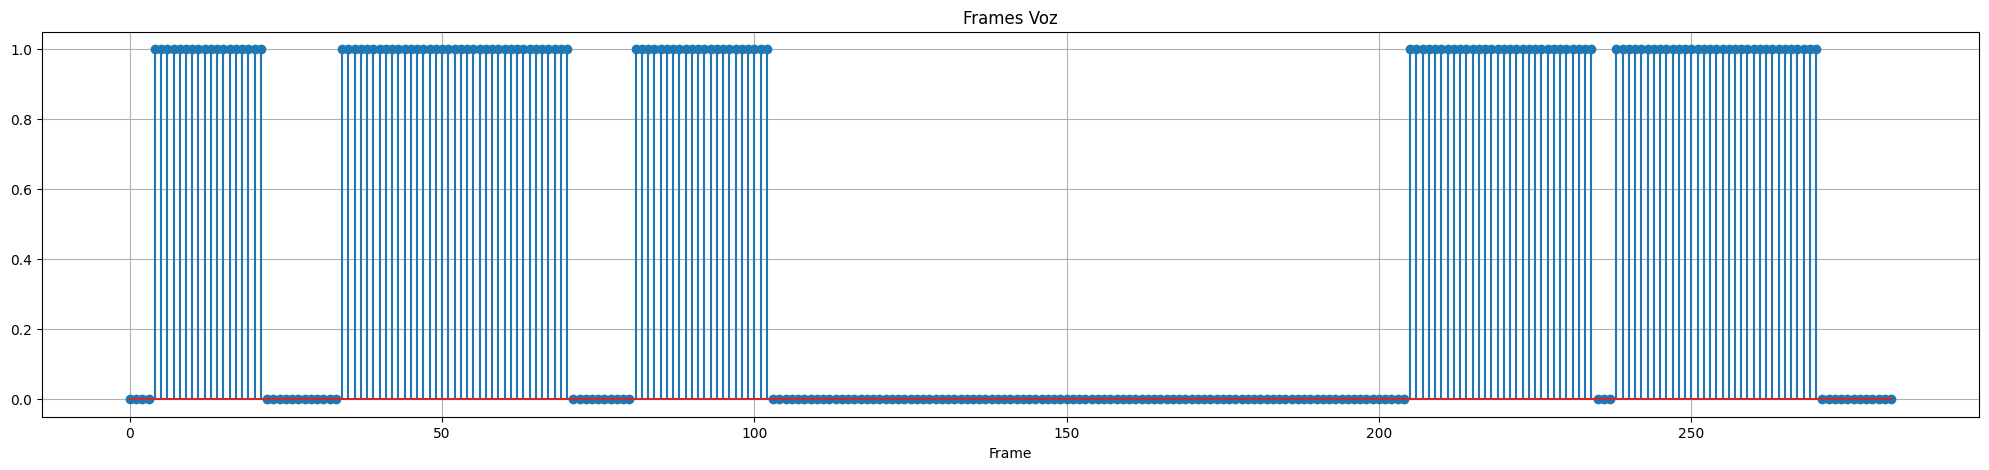

In [18]:
plt.figure(5)
plt.figure(figsize=(25,5))
plt.stem(detecVoz)
plt.grid()
plt.title('Frames Voz') 
plt.xlabel('Frame')
#plt.xticks(np.arange(0, nFrames+1, step=1))
plt.show()

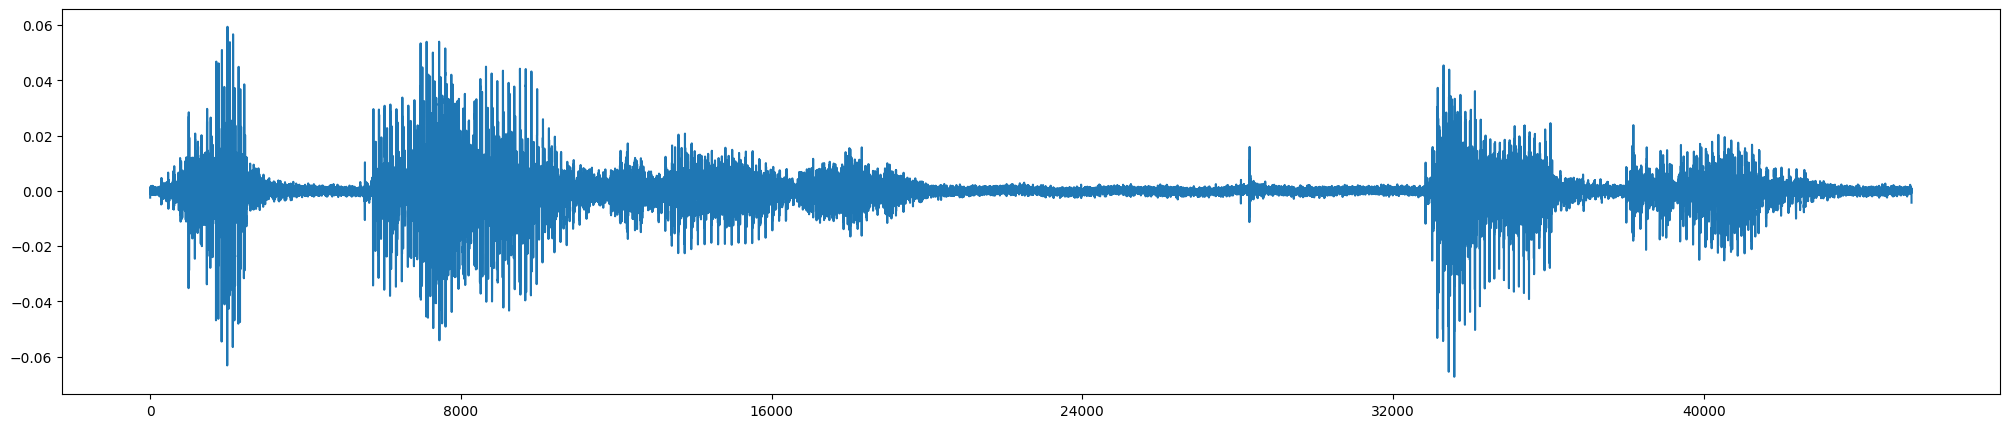

In [19]:
plt.figure(figsize=(25,5))
plt.xticks(np.arange(0, len(emphasized_signal), step=8000))
plt.plot(emphasized_signal)

In [20]:
vozeado = np.concatenate(sinal_vozeado)

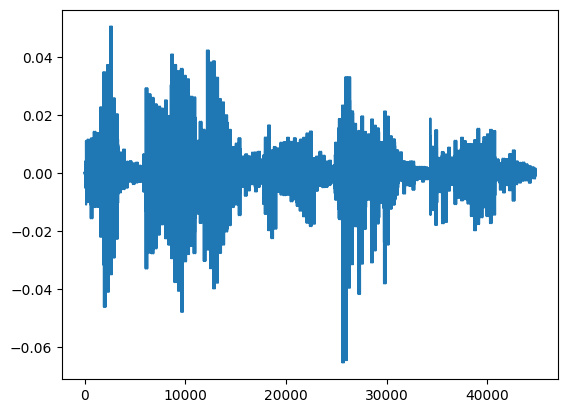

In [21]:
plt.plot(vozeado)

In [22]:
autocorrelacao = librosa.autocorrelate(vozeado)

In [23]:
peaks = find_peaks(autocorrelacao, distance=80)[0]

(320.0, 1600.0)

<Figure size 2000x500 with 0 Axes>

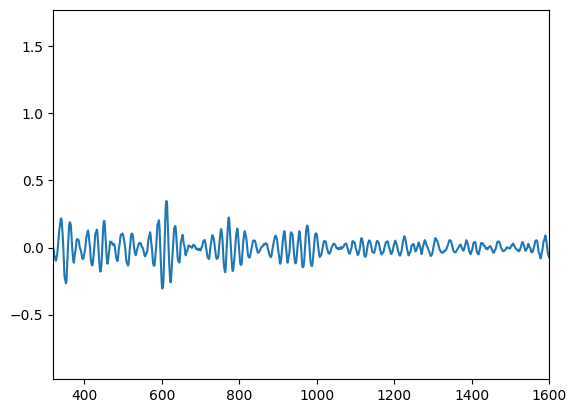

In [24]:
fig1 = plt.figure(figsize=(20,5))
fig1, ax = plt.subplots()
plt.plot(autocorrelacao)
ax.set_xlim(320*1, 320*5)
#plt.plot(peaks, autocorrelacao[peaks], "x")

In [25]:
S = np.abs(librosa.stft(autocorrelacao))

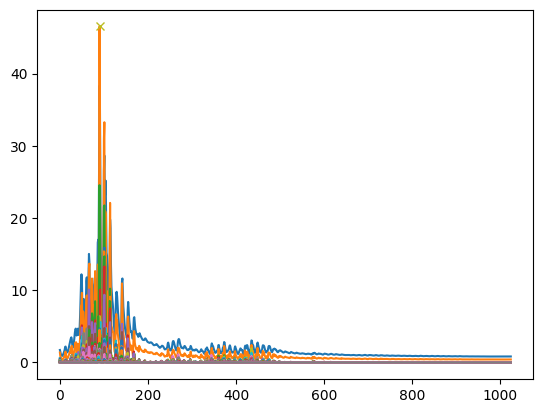

In [26]:
plt.plot(S)
plt.plot(90, np.max(S), "x")

In [27]:
np.where(S == np.max(S))

(array([90]), array([1]))

<Figure size 2000x2000 with 0 Axes>

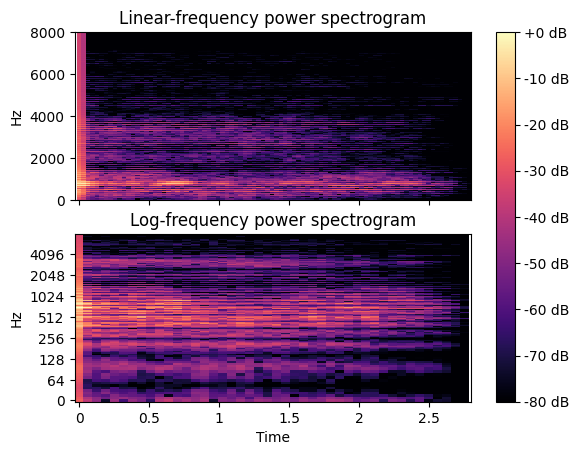

In [45]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(autocorrelacao)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=fs, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram')
ax[0].label_outer()
hop_length = 1024
D = librosa.amplitude_to_db(np.abs(librosa.stft(autocorrelacao, hop_length=hop_length)), ref=np.max)
librosa.display.specshow(D, y_axis='log', sr=fs, hop_length=hop_length, x_axis='time', ax=ax[1])
ax[1].set(title='Log-frequency power spectrogram')
ax[1].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")